In [44]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform) 
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size=100, shuffle=True) 
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=100, shuffle=False)

En fait ToTensor() scale l'image entre 0 et 1 et normalize fait la normalization

In [45]:
print( "Dans le dataset, les valeurs des pixels vont de", training_loader.dataset.data[0].min(), "à", training_loader.dataset.data[0].max())
ins, labs = next(iter(training_loader))
print( "Dans le dataset, les valeurs des pixels vont de", ins[0].min(), "à", ins[0].max())

Dans le dataset, les valeurs des pixels vont de tensor(0, dtype=torch.uint8) à tensor(255, dtype=torch.uint8)
Dans le dataset, les valeurs des pixels vont de tensor(-1.) à tensor(1.)


In [49]:
training_loader.dataset.data.shape, ins.shape

(torch.Size([60000, 28, 28]), torch.Size([100, 1, 28, 28]))

In [2]:
torch.backends.cudnn.enabled

True

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# note : a partir de l'epoch 7, on voit des signes d'overfitting : on rajoute donc un dropout layer : ça force des neurone à 0 de manière aléatoire à chaque update durant le training et a priori ca réduit l'overfitting
# LES DROPOUT se font de manière différente sur les différents exemples et changent à chaque itération. 
# on utilise typiquement un dropout layer entre des couches qui ont un nombre important de paramètres
# le dropout n'est utilisé que pendant la phase de training, pas pour tester d'autres data
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        

        # convolution layers
        in_channels1 = 1 # one channel per input (grayscale image)
        out_channels1 = in_channels2 = 20 # kernel convolution is applied to yield a depth of 20 (20 different kernels)
        out_channels2 = 50 # kernel convolution is applied to yield a depth of 20 (20 different kernels)
        kernel_size = 5 # if single int, same dimension on width and height
        stride = 1 # number of pixel to move 
        self.conv1 = nn.Conv2d(in_channels=in_channels1, out_channels=out_channels1, kernel_size=kernel_size, stride=stride)
        # the number of output channels of conv1 is the same as the number of input channels of conv2. (an input of conv2 is the output of conv1 after relu and pooling)
        self.conv2 = nn.Conv2d(in_channels=in_channels2, out_channels=out_channels2, kernel_size=kernel_size, stride=stride)

        # fully connected layers
        image_size = 28 #28*28images
        pool_stride = 2
        # no padding here so after conv1, each feature map loses kernel_size-1 pixel layers from top, bottom, left and right. So 28*28 becomes 24*24 here
        # pooling divides by 2 (on regarde le stride du pooling, l'image finale est de taille image_size/stride pooling arrondie au supérieur) => 12*12 
        # convolution -> devient 8*8 et pooling => 4*4 puis nombre d'inputs de fc1 = 4*4*50
        in_fc1 = int(np.ceil((np.ceil((image_size-(kernel_size-1))/pool_stride)-(kernel_size-1))/pool_stride)**2*out_channels2)
        out_fc1 = in_fc2 = 500
        self.fc1 = nn.Linear(in_features=in_fc1, out_features=out_fc1)

        #ajout du dropout entre les fully connected layers
        self.dropout1 = nn.Dropout(p=0.5) #50% of neurons turned off during training


        self.fc2 = nn.Linear(500,10) #classification

        


    def forward(self, x, dropout=False):
        pool_stride = 2
        pool_size = 2
        c1 = nn.functional.relu(self.conv1(x))
        p1 = nn.functional.max_pool2d(c1, kernel_size=pool_size, stride=pool_stride)
        c2 = nn.functional.relu(self.conv2(p1))
        p2 = nn.functional.max_pool2d(c2, kernel_size=pool_size, stride=pool_stride)
        flattened = p2.view(-1,4*4*50) # -1 here so that number of columns is maintained

        h = nn.functional.relu(self.fc1(flattened))

        if dropout: 
            h = self.dropout1(h) #not done in the video but you should disable dropout on test data

        score = self.fc2(h) #raw score here
        return score



In [6]:
LeNet()

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [7]:
pp = nn.Dropout(0.5)

aa = torch.rand(4,4)
pp(aa)

tensor([[0.3657, 0.5705, 0.0000, 1.3934],
        [1.8989, 0.6783, 0.0000, 1.7110],
        [0.0576, 0.0000, 1.0808, 0.0000],
        [0.0000, 0.5553, 0.1204, 0.0000]])

In [8]:
# 1 epoch avec le cpu = 40s contre 15s avec le gpu
model = LeNet().to(device) # model is on gpu
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.0001)
epochs = 15

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader: #les inputs sont de dimension 100 * 1 * 28 * 28 (100 mesures, 1 channel, 28*28 pixels). no need to flatten them this time

        inputs = inputs.to(device) # use gpu
        labels = labels.to(device)

       
        outputs = model.forward(inputs, dropout=True) 
        loss = criterion(outputs, labels) # see docs, it is normal, input is raw score and labels is class number of target. here loss is a minibatch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1) #preds is the index of the max value for the 100 images

        running_loss += loss.item()* inputs.size(0) # ma loss est moyennée donc je la multiplie par le nombre d'inputs
        running_corrects += torch.sum(preds == labels)
    else:
    #runs after for loop ends. not rly useful 
        with torch.no_grad():
        # no need to compute derivative on validation set so we save memory
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model.forward(val_inputs, dropout=False)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs,1) #preds is the index of the max value for the 100 images
                val_running_loss += val_loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels)



    epoch_loss = running_loss/len(training_loader.dataset) # comme j'ai multiplié ma loss par inputs.size(0), je divise par le nombre dans le dataset
    epoch_acc = running_corrects/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print("training loss: {:4f}, accuracy : {:4f}".format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(validation_loader.dataset) 
    val_epoch_acc = val_running_corrects/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print("validation loss: {:4f}, accuracy : {:4f}".format(val_epoch_loss, val_epoch_acc.item()))

training loss: 0.005837, accuracy : 0.843483
validation loss: 0.001541, accuracy : 0.954200
training loss: 0.001500, accuracy : 0.956000
validation loss: 0.000910, accuracy : 0.971900
training loss: 0.001016, accuracy : 0.969717
validation loss: 0.000622, accuracy : 0.980200
training loss: 0.000800, accuracy : 0.975967
validation loss: 0.000516, accuracy : 0.983500
training loss: 0.000662, accuracy : 0.980167
validation loss: 0.000433, accuracy : 0.986400
training loss: 0.000567, accuracy : 0.982983
validation loss: 0.000365, accuracy : 0.988800
training loss: 0.000505, accuracy : 0.984600
validation loss: 0.000344, accuracy : 0.989500
training loss: 0.000448, accuracy : 0.986517
validation loss: 0.000314, accuracy : 0.990100
training loss: 0.000405, accuracy : 0.987383
validation loss: 0.000309, accuracy : 0.989100
training loss: 0.000370, accuracy : 0.988367
validation loss: 0.000284, accuracy : 0.991000
training loss: 0.000344, accuracy : 0.989450
validation loss: 0.000278, accuracy

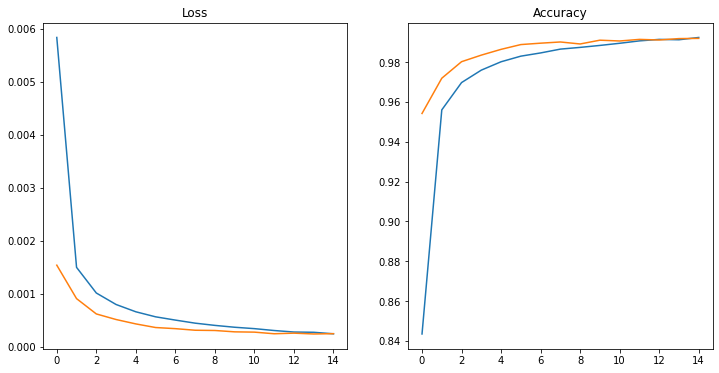

In [9]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")

<Response [200]>


tensor([5], device='cuda:0')

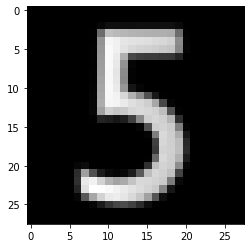

In [10]:
import requests
import PIL
from PIL import Image, ImageOps
def img_transform(img):
    img = Image.open(img)
    img = ImageOps.invert(img)
    img = ImageOps.grayscale(img)
    img = transform(img) # apply the transform defined on top
    return img
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #1*28*28
    # image = image.transpose(1,2) #28*28*1
    image = image[0]
    image = image * np.array([0.5])+ np.array([0.5]) #reverse normalisation
    image.clip(0,1) #ensures range is between 0 and 1
    return image


url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream=True)
img = img_transform(response.raw)
print(response)
plt.imshow(im_convert(img), cmap="gray")
scores = model.forward(img.unsqueeze(0).to(device)) # unsqueeze to add a dim, to device to use gpu
_,  pred= torch.max(scores,1)
pred

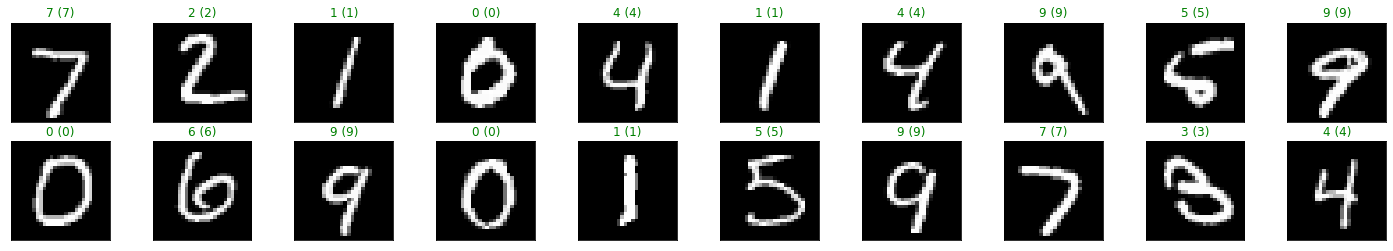

In [11]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
outputs = model.forward(images)
_, preds = torch.max(outputs,1)
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx + 1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]), cmap="gray")
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]== labels[idx] else "red"))

# ca marche mieux

torch.return_types.max(
values=tensor([3.9344], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4], device='cuda:0'))

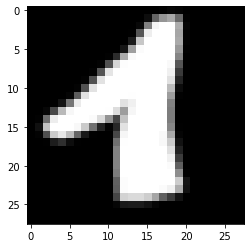

In [12]:
img = img_transform("data/paint/onethickpaint.png").to(device)
plt.imshow(im_convert(img), cmap='gray')
test_outputs = model.forward(img.unsqueeze(0))
pred = torch.max(test_outputs,1)
pred

torch.return_types.max(
values=tensor([5.4694], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

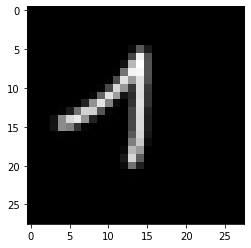

In [13]:
img = img_transform("data/paint/onepaint.png").to(device)
plt.imshow(im_convert(img), cmap='gray')
test_outputs = model.forward(img.unsqueeze(0))
pred = torch.max(test_outputs,1)
pred

torch.return_types.max(
values=tensor([6.7560], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3], device='cuda:0'))

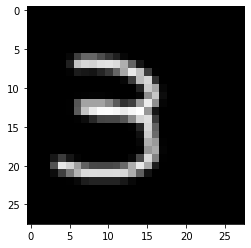

In [14]:
img = img_transform("data/paint/threepaint.png").to(device)
plt.imshow(im_convert(img), cmap='gray')
test_outputs = model.forward(img.unsqueeze(0))
pred = torch.max(test_outputs,1)
pred

torch.return_types.max(
values=tensor([2.1255], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4], device='cuda:0'))

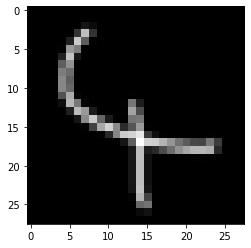

In [15]:
#echec sans le dropout, marche avec le dropout mais seulement si je m'arrête à 15 epochs
img = img_transform("data/paint/fourpaint.png").to(device)
plt.imshow(im_convert(img), cmap='gray')
test_outputs = model.forward(img.unsqueeze(0))
pred = torch.max(test_outputs,1)
pred

torch.return_types.max(
values=tensor([2.0426], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4], device='cuda:0'))

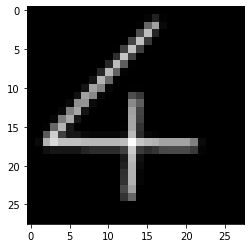

In [16]:
#du mal avec les 4
img = img_transform("data/paint/fourpaint2.png").to(device)
plt.imshow(im_convert(img), cmap='gray')
test_outputs = model.forward(img.unsqueeze(0))
pred = torch.max(test_outputs,1)
pred